## Plot feature distribution over time

In [35]:
import pandas as pd

races_df = pd.read_csv("../data/races.csv")

races_df

,Unnamed: 0,date_time,race_id,n_runners,number,current_odds,current_place_odds,place,relevance,Current_Odds_Feature,...,Distance_Difference,Class_Difference,Has_Jockey_Changed,Purse,Average_Place_Lifetime,Average_Place_Track,Jockey_Weight,Max_Past_Rating,Weight_Allowance,Average_Place_Surface
0,0,2018-01-01 13:05:00,2441830,6,1,2.87,1.46,1,30,2.87,...,-5.0,0.0,1.0,32500.000000,7.000000,NaN,59.0,NaN,0.0,NaN
1,1,2018-01-01 13:05:00,2441830,6,2,15.00,4.50,3,20,15.00,...,-207.0,0.0,1.0,8666.666667,6.666667,NaN,55.8,NaN,0.0,NaN
2,2,2018-01-01 13:05:00,2441830,6,3,5.50,2.12,4,8,5.50,...,-207.0,-1.0,1.0,5560.000000,5.000000,NaN,55.8,NaN,0.0,NaN
3,3,2018-01-01 13:05:00,2441830,6,4,2.25,1.31,2,28,2.25,...,-207.0,0.0,0.0,5375.000000,3.333333,NaN,53.5,NaN,0.0,NaN
4,4,2018-01-01 13:05:00,2441830,6,5,101.00,26.00,6,0,101.00,...,-5.0,0.0,0.0,5000.000000,10.000000,NaN,53.5,NaN,0.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
418307,418307,2022-10-12 21:30:00,5430097,11,9,51.00,11.00,10,0,51.00,...,0.0,0.0,1.0,8450.000000,6.083333,9.000000,59.9,75.0,2.3,9.000000
418308,418308,2022-10-12 21:30:00,5430097,11,10,7.50,2.30,1,30,7.50,...,201.0,0.0,1.0,6384.615385,6.846154,9.666667,59.4,52.0,0.0,9.666667
418309,418309,2022-10-12 21:30:00,5430097,11,11,81.00,17.00,9,0,81.00,...,-201.0,0.0,0.0,7333.333333,7.833333,8.200000,59.0,NaN,2.3,7.833333
418310,418310,2022-10-12 21:30:00,5430097,11,12,15.00,3.80,5,21,15.00,...,201.0,0.0,1.0,7608.064516,5.483871,5.000000,59.0,51.0,1.4,4.972222


                  std
year-month           
2018-01     36.955593
2018-02     38.000446
2018-03     37.957252
2018-04     39.229833
2018-05     38.379149
2018-06     34.136574
2018-07     33.532915
2018-08     30.270890
2018-09     27.111897
2018-10     26.721616
2018-11     28.421486
2018-12     29.611304
2019-01     27.642675
2019-02     28.409272
2019-03     28.416150
2019-04     27.006241
2019-05     26.279217
2019-06     25.692587
2019-07     24.335280
2019-08     22.471360
2019-09     22.348411
2019-10     24.335929
2019-11     26.786753
2019-12     27.011109
2020-01     26.049646
2020-02     26.300994
2020-03     27.329613
2020-06     20.908744
2020-07     23.159508
2020-08     23.562648
2020-09     22.845814
2020-10     24.129261
2020-11     26.827005
2020-12     26.822460
2021-01     24.617668
2021-02     28.314198
2021-03     30.306948
2021-04     26.675065
2021-05     26.188525
2021-06     23.962752
2021-07     21.128307
2021-08     19.854111
2021-09     20.163383
2021-10   

<AxesSubplot:xlabel='Current_Speed_Figure', ylabel='year-month'>

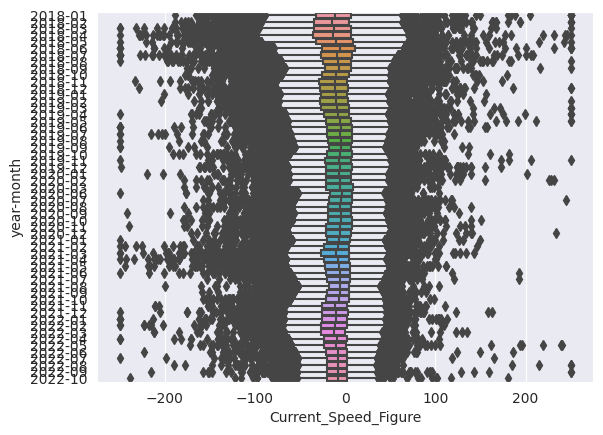

In [36]:
import seaborn as sns

COLUMN_NAME = "Current_Speed_Figure"
TIME_INTERVAL = "year-month"

races_df["year-month"] = races_df["date_time"].astype(str).str[:7]
races_df["date"] = pd.to_datetime(races_df["date_time"], format='%Y-%m-%d')
races_df["dayofweek"] = races_df["date"].dt.dayofweek.astype(str)
races_df["hour"] = races_df["date"].dt.hour.astype(str)
races_df["minute"] = races_df["date"].dt.minute.astype(str)
races_df["month"] = races_df["date"].dt.month.astype(str)

print(races_df.groupby([TIME_INTERVAL]).agg(std=(COLUMN_NAME, "std")))

sns.boxplot(data=races_df, x=COLUMN_NAME, y=TIME_INTERVAL)

# Covariate Shift Detection

## 1.) Between a month and its predecessor

In [51]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
import numpy as np

races_df = pd.read_csv("../data/races.csv")
races_df["year-month"] = races_df["date_time"].astype(str).str[:7]

month_df = races_df[races_df["year-month"].isin(["2022-09", "2022-08"])]
month_df["label"] = np.where(month_df["year-month"] == "2022-09", 1, 0)

month_df = month_df.fillna(value=-1)

month_df = month_df.drop(["date_time", "race_id", "horse_id", "year-month", "Month_Sin", "Month_Cos", "Unnamed: 0"], axis=1)

print(month_df)

features = [column for column in month_df.columns if column not in ["label"]]
shift_X = month_df.loc[:, features]
scaler = StandardScaler().fit(shift_X)
shift_X = scaler.transform(shift_X)

shift_y = month_df.loc[:, "label"]

X_train, X_test, y_train, y_test = train_test_split(shift_X, shift_y, test_size=0.33, random_state=42, stratify=shift_y)

log_regression_classifier = LogisticRegression(random_state=0).fit(X_train, y_train)
print(f"Classifier score:{log_regression_classifier.score(X_test, y_test)}")

coef_data = {
    "feature name": list([column for column in features]),
    "coeff": list(list(log_regression_classifier.coef_)[0]),
}

coeff_df = pd.DataFrame.from_dict(coef_data)
coeff_df.sort_values(by=["coeff"])

       n_runners  current_odds  current_place_odds  place  has_won  relevance  \
80410         11          4.20                1.64      6        0         27   
80411         11         67.00               14.20      9        0         25   
80412         11         15.00                3.80      3        0         30   
80413         11         41.00                9.00     11        0         17   
80414         11         12.00                3.20      4        0         29   
...          ...           ...                 ...    ...      ...        ...   
92525         10          3.75                1.55      4        0         26   
92526         10         11.00                3.00      9        0         22   
92527         10         12.00                3.20      5        0         25   
92528         10         10.00                2.80      1        1         30   
92529         10         17.00                4.20      3        0         29   

       Current_Odds_Feature

/tmp/ipykernel_8287/2015652303.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  month_df["label"] = np.where(month_df["year-month"] == "2022-09", 1, 0)


,feature name,coeff
12,Draw_Bias,-0.377124
10,Age,-0.294436
1,current_odds,-0.280174
6,Current_Odds_Feature,-0.280174
11,Current_Rating,-0.240611
18,Hour_Cos,-0.177859
8,Current_Race_Class,-0.164490
14,Current_Race_Track,-0.159514
48,Average_Place_Surface,-0.119077
45,Jockey_Weight,-0.095458
